# Chapter 10 – Introduction to Artificial Neural Networks with Keras

This notebook contains all the sample code and solutions to the exercises in chapter 10.

## Setup
This project requires Python 3.7 or above:

In [2]:

import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/ann``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## From Biological to Artificial Neurons
### The Perceptron

In [7]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [8]:
y_pred

array([ True, False])

The ```Perceptron``` is equivalent to a ```SGDClassifier``` with ```loss="perceptron"```, no regularization, and a constant learning rate equal to 1:

In [9]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

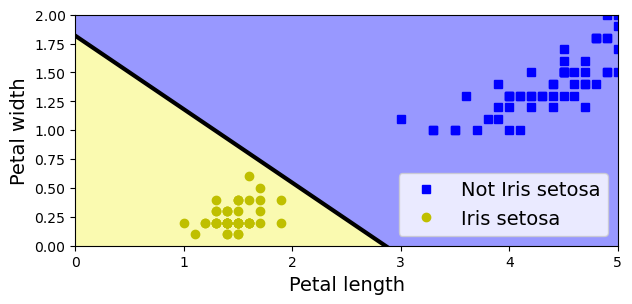

In [10]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

### Activation functions

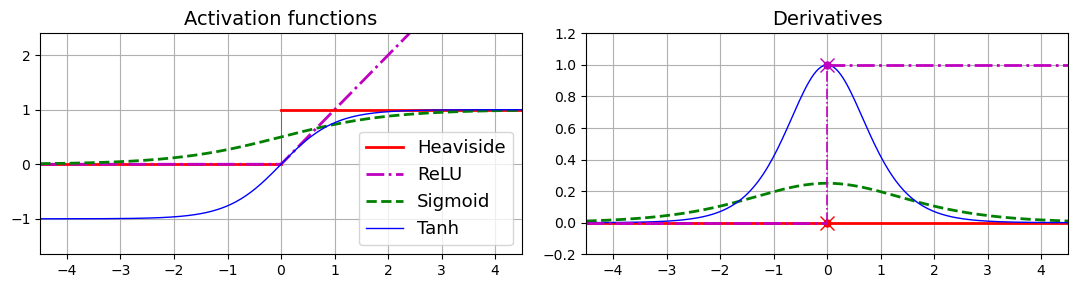

In [11]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

### Regression MLPs

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

In [13]:
rmse

0.5053326657968666

### Classification MLPs

In [14]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

## Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in tf.keras.datasets. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [15]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [16]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [17]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [18]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's ```imshow()``` function, with a ```'binary'``` color map:

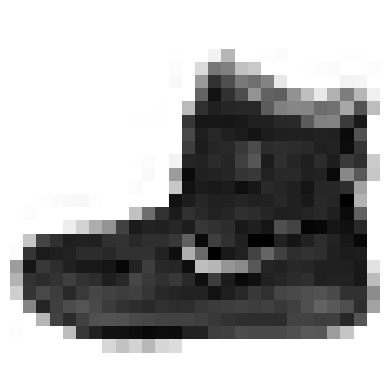

In [19]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [20]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [22]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

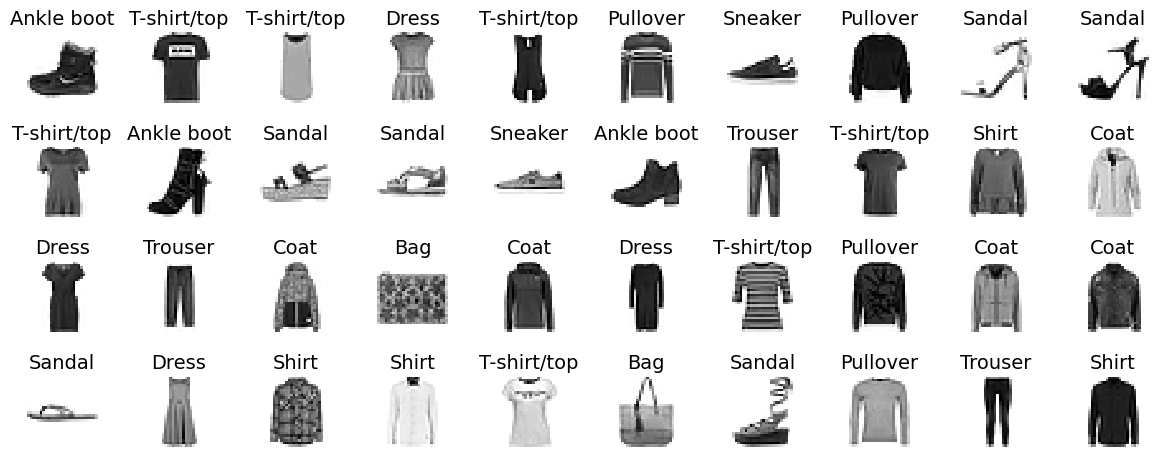

In [23]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

## Creating the model using the Sequential API

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [25]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
model.layers

In [29]:

hidden1 = model.layers[1]
hidden1.name

'dense'

In [30]:
model.get_layer('dense') is hidden1

True

In [31]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02629834,  0.06838802,  0.06104968, ...,  0.02861779,
        -0.05672184,  0.03294159],
       [-0.06108467,  0.02908857,  0.06831874, ...,  0.04051446,
        -0.05040023, -0.07206711],
       [ 0.00774747, -0.00466685,  0.04560872, ..., -0.06296156,
         0.07314666,  0.06567407],
       ...,
       [-0.0008075 , -0.01960498,  0.06472854, ...,  0.00022142,
        -0.07318552, -0.0497335 ],
       [ 0.01615062,  0.03875927,  0.00477573, ..., -0.028209  ,
        -0.05900072,  0.01831511],
       [ 0.02457085, -0.04476357, -0.0664579 , ...,  0.00063794,
        -0.01496105,  0.06248379]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

### Compiling the model

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [36]:

# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [37]:

# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set ```num_classes``` when the number of classes is greater than the maximum class id in the sample.

In [38]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

### Training and evaluating the model

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


1719/1719 [==============================] - 2s 858us/step - loss: 0.6909 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.4986 - val_sparse_categorical_accuracy: 0.8284
Epoch 2/30
1719/1719 [==============================] - 1s 795us/step - loss: 0.4760 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.4623 - val_sparse_categorical_accuracy: 0.8332
Epoch 3/30
1719/1719 [==============================] - 1s 802us/step - loss: 0.4321 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.4239 - val_sparse_categorical_accuracy: 0.8530
Epoch 4/30
1719/1719 [==============================] - 1s 786us/step - loss: 0.4085 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.3938 - val_sparse_categorical_accuracy: 0.8642
Epoch 5/30
1719/1719 [==============================] - 1s 787us/step - loss: 0.3885 - sparse_categorical_accuracy: 0.8649 - val_loss: 0.3892 - val_sparse_categorical_accuracy: 0.8606
Epoch 6/30
1719/1719 [==============================] - 1s 785us/step - loss: 

In [40]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [41]:

print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


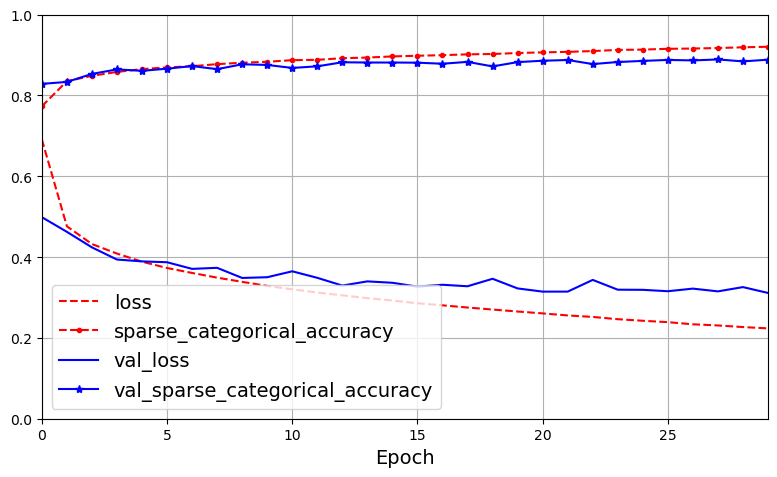

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

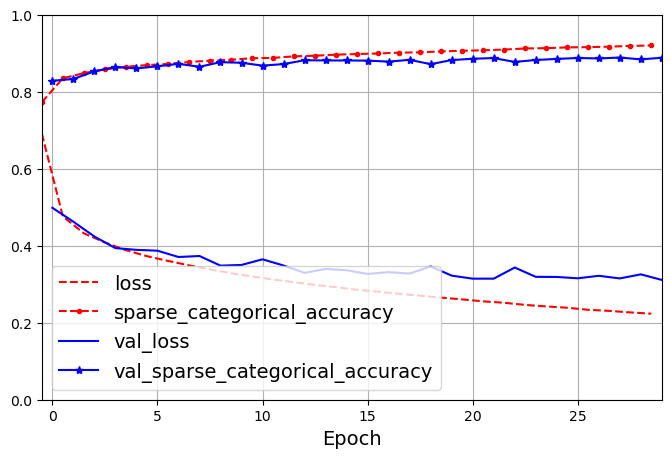

In [43]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [44]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 598us/step - loss: 0.3307 - sparse_categorical_accuracy: 0.8819


[0.330658495426178, 0.8819000124931335]

### Using the model to make predictions

In [45]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 53ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [46]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [47]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [48]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

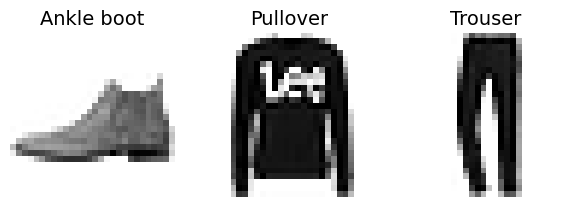

In [49]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### Building a Regression MLP Using the Sequential API
Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [50]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [51]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 938us/step - loss: 0.9108 - root_mean_squared_error: 0.9544 - val_loss: 0.3748 - val_root_mean_squared_error: 0.6122
Epoch 2/20
363/363 [==============================] - 0s 763us/step - loss: 0.3820 - root_mean_squared_error: 0.6181 - val_loss: 0.8428 - val_root_mean_squared_error: 0.9180
Epoch 3/20
363/363 [==============================] - 0s 793us/step - loss: 0.3560 - root_mean_squared_error: 0.5966 - val_loss: 0.4002 - val_root_mean_squared_error: 0.6326
Epoch 4/20
363/363 [==============================] - 0s 745us/step - loss: 0.3437 - root_mean_squared_error: 0.5863 - val_loss: 0.5311 - val_root_mean_squared_error: 0.7288
Epoch 5/20
363/363 [==============================] - 0s 744us/step - loss: 0.3301 - root_mean_squared_error: 0.5745 - val_loss: 1.5546 - val_root_mean_squared_error: 1.2468
Epoch 6/20
363/363 [==============================] - 0s 756us/step - loss: 0.3287 - root_mean_squared_error: 0.5733 - val_loss: 0

In [52]:

rmse_test

0.5400587320327759

In [53]:

y_pred

array([[0.377276 ],
       [1.1790974],
       [5.4747863]], dtype=float32)

### Building Complex Models Using the Functional API
Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see paper) connects all or part of the inputs directly to the output layer.

In [54]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [55]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 932us/step - loss: 1.1426 - root_mean_squared_error: 1.0689 - val_loss: 0.8497 - val_root_mean_squared_error: 0.9218
Epoch 2/20
363/363 [==============================] - 0s 724us/step - loss: 0.4690 - root_mean_squared_error: 0.6849 - val_loss: 1.0640 - val_root_mean_squared_error: 1.0315
Epoch 3/20
363/363 [==============================] - 0s 720us/step - loss: 0.3977 - root_mean_squared_error: 0.6306 - val_loss: 0.3796 - val_root_mean_squared_error: 0.6161
Epoch 4/20
363/363 [==============================] - 0s 719us/step - loss: 0.3702 - root_mean_squared_error: 0.6084 - val_loss: 0.3900 - val_root_mean_squared_error: 0.6245
Epoch 5/20
363/363 [==============================] - 0s 727us/step - loss: 0.3647 - root_mean_squared_error: 0.6039 - val_loss: 0.3680 - val_root_mean_squared_error: 0.6067
Epoch 6/20
363/363 [==============================] - 0s 728us/step - loss: 0.3494 - root_mean_squared_error: 0.5911 - val_loss: 0

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [58]:
tf.random.set_seed(42)  # extra code

In [59]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 957us/step - loss: 1.5757 - root_mean_squared_error: 1.2553 - val_loss: 0.6276 - val_root_mean_squared_error: 0.7922
Epoch 2/20
363/363 [==============================] - 0s 764us/step - loss: 0.5408 - root_mean_squared_error: 0.7354 - val_loss: 0.8928 - val_root_mean_squared_error: 0.9449
Epoch 3/20
363/363 [==============================] - 0s 758us/step - loss: 0.4583 - root_mean_squared_error: 0.6770 - val_loss: 0.4316 - val_root_mean_squared_error: 0.6570
Epoch 4/20
363/363 [==============================] - 0s 755us/step - loss: 0.4220 - root_mean_squared_error: 0.6496 - val_loss: 0.6295 - val_root_mean_squared_error: 0.7934
Epoch 5/20
363/363 [==============================] - 0s 754us/step - loss: 0.4014 - root_mean_squared_error: 0.6335 - val_loss: 0.3619 - val_root_mean_squared_error: 0.6015
Epoch 6/20
363/363 [==============================] - 0s 755us/step - loss: 0.3857 - root_mean_squared_error: 0.6211 - val_loss: 0

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [62]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

Warning: in recent versions, Keras requires one metric per output, so I replaced ```metrics=["RootMeanSquaredError"]``` with ```metrics=["RootMeanSquaredError", "RootMeanSquaredError"]``` in the code below.

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [64]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.7670 - dense_2_loss: 1.6909 - dense_3_loss: 2.4515 - dense_2_root_mean_squared_error: 1.3003 - dense_3_root_mean_squared_error: 1.5657 - val_loss: 0.7746 - val_dense_2_loss: 0.7311 - val_dense_3_loss: 1.1661 - val_dense_2_root_mean_squared_error: 0.8550 - val_dense_3_root_mean_squared_error: 1.0799
Epoch 2/20
363/363 [==============================] - 0s 849us/step - loss: 0.6377 - dense_2_loss: 0.6186 - dense_3_loss: 0.8090 - dense_2_root_mean_squared_error: 0.7865 - dense_3_root_mean_squared_error: 0.8994 - val_loss: 0.6173 - val_dense_2_loss: 0.6011 - val_dense_3_loss: 0.7630 - val_dense_2_root_mean_squared_error: 0.7753 - val_dense_3_root_mean_squared_error: 0.8735
Epoch 3/20
363/363 [==============================] - 0s 855us/step - loss: 0.5257 - dense_2_loss: 0.5134 - dense_3_loss: 0.6362 - dense_2_root_mean_squared_error: 0.7165 - dense_3_root_mean_squared_error: 0.7976 - val_loss: 0.5271 - val_dense_2_

In [65]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

print(eval_results)
#weighted_sum_of_losses, main_loss, aux_loss = eval_results

162/162 [==============================] - 0s 563us/step - loss: 0.3261 - dense_2_loss: 0.3199 - dense_3_loss: 0.3812 - dense_2_root_mean_squared_error: 0.5656 - dense_3_root_mean_squared_error: 0.6174
[0.3260682225227356, 0.3199436068534851, 0.3811897039413452, 0.5656355619430542, 0.6174056529998779]


In [66]:

y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 39ms/step


In [67]:

y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 12ms/step


### Using the Subclassing API to Build Dynamic Models

In [68]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

Warning: as explained above, Keras now requires one metric per output, so I replaced ```metrics=["RootMeanSquaredError"]``` with ```metrics=["RootMeanSquaredError", "RootMeanSquaredError"]``` in the code below. Note: not required anymore, actually throws an error

In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8132 - output_1_loss: 1.8202 - output_2_loss: 1.7495 - output_1_root_mean_squared_error: 1.3492 - output_2_root_mean_squared_error: 1.3227 - val_loss: 1.7341 - val_output_1_loss: 1.8057 - val_output_2_loss: 1.0897 - val_output_1_root_mean_squared_error: 1.3438 - val_output_2_root_mean_squared_error: 1.0439
Epoch 2/10
363/363 [==============================] - 0s 845us/step - loss: 0.6453 - output_1_loss: 0.6430 - output_2_loss: 0.6661 - output_1_root_mean_squared_error: 0.8018 - output_2_root_mean_squared_error: 0.8161 - val_loss: 1.1652 - val_output_1_loss: 1.2025 - val_output_2_loss: 0.8292 - val_output_1_root_mean_squared_error: 1.0966 - val_output_2_root_mean_squared_error: 0.9106
Epoch 3/10
363/363 [==============================] - 0s 850us/step - loss: 0.5114 - output_1_loss: 0.5058 - output_2_loss: 0.5619 - output_1_root_mean_squared_error: 0.7112 - output_2_root_mean_squared_error: 0.7496 - val_loss: 0

### Saving and Restoring a Model


**Warning**: Keras now recommends using the ```.keras``` format to save models, and the ```h5``` format for weights. Therefore I have updated the code in this section to first show what you need to change if you still want to use TensorFlow's SavedModel format, and then how you can use the recommended formats.

In [70]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)


**Warning**: Keras's ```model.save()``` method no longer supports TensorFlow's ```SavedModel``` format. However, you can still export models to the ```SavedModel``` format using ```model.export()``` like this:

In [71]:

model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_1'), TensorSpec(shape=(None, 6), dtype=tf.float32, name='input_2')]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  1523868625808: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  1523868338832: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  1523868339536: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  1523869116272: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  1523872369824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1523869118032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1523870466464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1523869108176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1523872382320: TensorSpec(shape=(), dtyp

In [72]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\fingerprint.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


**Warning**: In Keras 3, it is no longer possible to load a TensorFlow ```SavedModel``` as a Keras model. However, you can load a ```SavedModel``` as a ```tf.keras.layers.TFSMLayer``` layer, but be aware that this layer can only be used for inference: no training.

In [73]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'TFSMLayer'

Warning: Keras now requires the saved weights to have the .weights.h5 extension. There are no longer saved using the SavedModel format.

In [74]:

model.save_weights("my_weights.weights.h5")

In [75]:
model.load_weights("my_weights.weights.h5")

To save a model using the ```.keras``` format, simply use ```model.save()```:

In [76]:
model.save("my_model.keras")

To load a ```.keras``` model, use the ```tf.keras.models.load_model()``` function. If the model uses any custom object, you must pass them to the function via the ```custom_objects``` argument:

In [77]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

### Using Callbacks

In [78]:

shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

**Warning**: as explained earlier, Keras now requires the checkpoint files to have a ```.weights.h5``` extension:

In [79]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 0s 922us/step - loss: 0.3452 - output_1_loss: 0.3386 - output_2_loss: 0.4041 - output_1_root_mean_squared_error: 0.5819 - output_2_root_mean_squared_error: 0.6357 - val_loss: 0.3808 - val_output_1_loss: 0.3801 - val_output_2_loss: 0.3872 - val_output_1_root_mean_squared_error: 0.6165 - val_output_2_root_mean_squared_error: 0.6222
Epoch 2/10
363/363 [==============================] - 0s 867us/step - loss: 0.3417 - output_1_loss: 0.3352 - output_2_loss: 0.4007 - output_1_root_mean_squared_error: 0.5790 - output_2_root_mean_squared_error: 0.6330 - val_loss: 0.9381 - val_output_1_loss: 0.9804 - val_output_2_loss: 0.5573 - val_output_1_root_mean_squared_error: 0.9901 - val_output_2_root_mean_squared_error: 0.7466
Epoch 3/10
363/363 [==============================] - 0s 873us/step - loss: 0.3410 - output_1_loss: 0.3348 - output_2_loss: 0.3973 - output_1_root_mean_squared_error: 0.5786 - output_2_root_mean_squared_error: 0.6304 - val_loss:

In [80]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 0s 922us/step - loss: 0.3238 - output_1_loss: 0.3182 - output_2_loss: 0.3741 - output_1_root_mean_squared_error: 0.5641 - output_2_root_mean_squared_error: 0.6116 - val_loss: 0.3163 - val_output_1_loss: 0.3110 - val_output_2_loss: 0.3640 - val_output_1_root_mean_squared_error: 0.5577 - val_output_2_root_mean_squared_error: 0.6033
Epoch 2/100
363/363 [==============================] - 0s 853us/step - loss: 0.3235 - output_1_loss: 0.3180 - output_2_loss: 0.3727 - output_1_root_mean_squared_error: 0.5639 - output_2_root_mean_squared_error: 0.6105 - val_loss: 0.3873 - val_output_1_loss: 0.3788 - val_output_2_loss: 0.4637 - val_output_1_root_mean_squared_error: 0.6155 - val_output_2_root_mean_squared_error: 0.6809
Epoch 3/100
363/363 [==============================] - 0s 867us/step - loss: 0.3202 - output_1_loss: 0.3148 - output_2_loss: 0.3694 - output_1_root_mean_squared_error: 0.5610 - output_2_root_mean_squared_error: 0.6078 - val_lo

In [81]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [82]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.02
Epoch=1, val/train=1.95
Epoch=2, val/train=1.03
Epoch=3, val/train=0.96
Epoch=4, val/train=1.88
Epoch=5, val/train=2.26
Epoch=6, val/train=1.09
Epoch=7, val/train=1.21
Epoch=8, val/train=1.75
Epoch=9, val/train=3.12


### Using TensorBoard for Visualization
TensorBoard is preinstalled on Colab, but not the ```tensorboard-plugin-profile```, so let's install it:

In [83]:
%pip install -q -U tensorboard-plugin-profile

Note: you may need to restart the kernel to use updated packages.


In [84]:
shutil.rmtree("my_logs", ignore_errors=True)

In [85]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [86]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [87]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.6381 - root_mean_squared_error: 1.2799 - val_loss: 0.9209 - val_root_mean_squared_error: 0.9596
Epoch 2/20
363/363 [==============================] - 0s 800us/step - loss: 0.6733 - root_mean_squared_error: 0.8206 - val_loss: 0.6923 - val_root_mean_squared_error: 0.8320
Epoch 3/20
363/363 [==============================] - 0s 799us/step - loss: 0.6074 - root_mean_squared_error: 0.7794 - val_loss: 0.5875 - val_root_mean_squared_error: 0.7665
Epoch 4/20
363/363 [==============================] - 0s 824us/step - loss: 0.5671 - root_mean_squared_error: 0.7531 - val_loss: 0.5270 - val_root_mean_squared_error: 0.7260
Epoch 5/20
363/363 [==============================] - 0s 822us/step - loss: 0.5369 - root_mean_squared_error: 0.7327 - val_loss: 0.4981 - val_root_mean_squared_error: 0.7057
Epoch 6/20
363/363 [==============================] - 0s 816us/step - loss: 0.5120 - root_mean_squared_error: 0.7155 - val_loss: 0.4

In [88]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_10_22_17_26_26
    plugins
      profile
        2024_10_22_22_26_31
          GREGNEWEGG.xplane.pb
    train
      events.out.tfevents.1729635991.GREGNEWEGG.21244.0.v2
    validation
      events.out.tfevents.1729635991.GREGNEWEGG.21244.1.v2


In [89]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

Reusing TensorBoard on port 6006 (pid 27144), started 6 days, 5:07:37 ago. (Use '!kill 27144' to kill it.)

http://localhost:6006/

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [90]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

Note: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [91]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6007: logdir my_fashion_mnisthyperbandtensorboard (started 6 days, 3:36:31 ago; pid 26504)
  - port 6006: logdir ./my_logs (started 6 days, 5:07:55 ago; pid 27144)


Next you can use the following command on Linux or MacOSX, replacing <pid> with the pid listed above:

```!kill <pid>```

On Windows:

```!taskkill /F /PID <pid>```

## Fine-Tuning Neural Network Hyperparameters
In this section we'll use the Fashion MNIST dataset again:

In [92]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [93]:

tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [94]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [95]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [96]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 16s]
val_accuracy: 0.8348000049591064

Best val_accuracy So Far: 0.8637999892234802
Total elapsed time: 00h 01m 17s


In [97]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [98]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [99]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8637999892234802


In [100]:
best_trial.metrics.get_last_value("val_accuracy")

0.8637999892234802

In [101]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 2s 812us/step - loss: 0.3355 - accuracy: 0.8775
Epoch 2/10
1875/1875 [==============================] - 2s 806us/step - loss: 0.3262 - accuracy: 0.8801
Epoch 3/10
1875/1875 [==============================] - 2s 815us/step - loss: 0.3163 - accuracy: 0.8848
Epoch 4/10
1875/1875 [==============================] - 2s 816us/step - loss: 0.3079 - accuracy: 0.8864
Epoch 5/10
1875/1875 [==============================] - 2s 824us/step - loss: 0.3014 - accuracy: 0.8889
Epoch 6/10
1875/1875 [==============================] - 2s 802us/step - loss: 0.2952 - accuracy: 0.8912
Epoch 7/10
1875/1875 [==============================] - 2s 801us/step - loss: 0.2878 - accuracy: 0.8930
Epoch 8/10
1875/1875 [==============================] - 2s 802us/step - loss: 0.2831 - accuracy: 0.8956
Epoch 9/10
1875/1875 [==============================] - 2s 819us/step - loss: 0.2765 - accuracy: 0.8975
Epoch 10/10
313/313 [==============================] - 0s 657us/

In [102]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [103]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [104]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 19s]
val_accuracy: 0.8353999853134155

Best val_accuracy So Far: 0.8812000155448914
Total elapsed time: 00h 08m 04s


In [105]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.8370000123977661

Best val_accuracy So Far: 0.8604000210762024
Total elapsed time: 00h 01m 59s


In [106]:
%tensorboard --logdir {root_logdir}

Reusing TensorBoard on port 6007 (pid 26504), started 6 days, 3:53:39 ago. (Use '!kill 26504' to kill it.)

## Exercise solutions

### 1. to 9.

1. Visit the TensorFlow Playground and play around with it, as described in this exercise (followed book prompts/guidance)

part a

part b

part c

part d

part e

part f 

part g


3. Why is it generally preferable to use a logistic regression classifier rather than a classic perceptron (i.e. a single layer of threshold logistic units trained using the perceptron training algorithm)? How can you tweak a perceptron to make it equivalent to a logistic regression classifier?

Book answer: A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.

chatbot answer: 

## Logistic Regression vs. Perceptron: A Comparative Analysis

**Logistic Regression** and **Perceptron** are both linear classification algorithms, but they have distinct characteristics and applications.

### Key Differences

1. **Output Interpretation:**
   * **Perceptron:** Outputs a binary value (0 or 1) directly.
   * **Logistic Regression:** Outputs a probability between 0 and 1. This allows for probabilistic predictions, which can be useful in many applications.

2. **Training Algorithm:**
   * **Perceptron:** Uses the perceptron learning rule, which is a simple iterative algorithm that updates weights based on misclassified examples.
   * **Logistic Regression:** Uses gradient descent or other optimization algorithms to minimize a loss function (often the cross-entropy loss). This allows for more flexible training and better convergence properties.

3. **Sensitivity to Outliers:**
   * **Perceptron:** Can be sensitive to outliers, as misclassified points can significantly affect the weight updates.
   * **Logistic Regression:** Less sensitive to outliers due to the use of a sigmoid activation function and gradient descent.

### Making a Perceptron Equivalent to Logistic Regression

To make a perceptron equivalent to a logistic regression classifier, you can use the following modifications:

1. **Sigmoid Activation Function:** Instead of using a simple threshold activation function, use a sigmoid activation function. This will map the weighted sum of inputs to a probability between 0 and 1.
2. **Loss Function:** Use a suitable loss function for logistic regression, such as cross-entropy loss. This loss function is designed to minimize the error between the predicted probabilities and the true labels.
3. **Optimization Algorithm:** Use a gradient-based optimization algorithm like gradient descent or stochastic gradient descent to update the weights.

**In essence, by incorporating these changes, you're essentially converting the perceptron into a logistic regression model.**

**In summary,** while both perceptrons and logistic regression are linear classifiers, logistic regression offers several advantages, including probabilistic outputs, better handling of outliers, and more flexible training. By modifying the perceptron's activation function, loss function, and optimization algorithm, you can make it equivalent to a logistic regression classifier.


4. Why was the sigmoid activation function a key ingredient in training the first MLPs?

Ans: The first MLPs were binary classification problems so they wanted to use an activation function that mimiced logistic regression. (wrong)

Book ans: The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.


5. Name three popular activation functions. Can you draw them?

relu, tanh and sigmoid

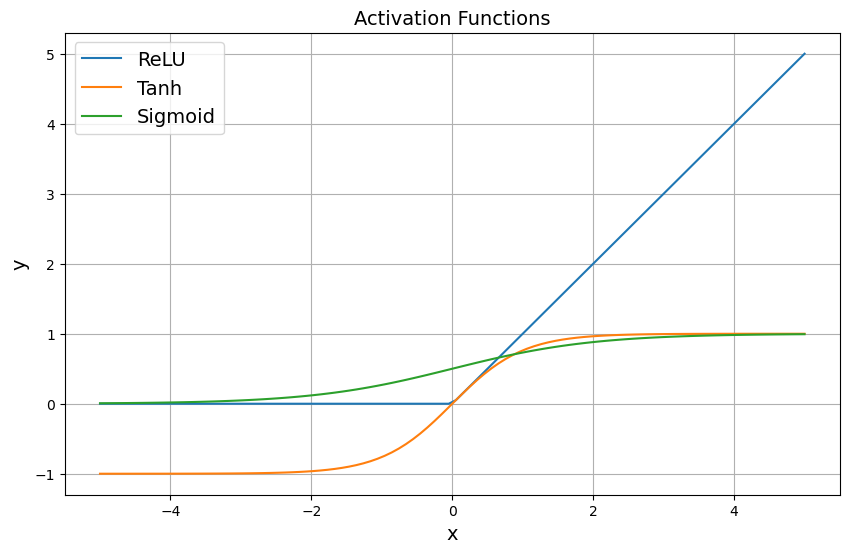

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Define the activation functions
def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Generate a range of x values
x = np.linspace(-5, 5, 100)

# Calculate the corresponding y values for each activation function
y_relu = relu(x)
y_tanh = tanh(x)
y_sigmoid = sigmoid(x)

# Plot the activation functions
plt.figure(figsize=(10, 6))
plt.plot(x, y_relu, label="ReLU")
plt.plot(x, y_tanh, label="Tanh")
plt.plot(x, y_sigmoid, label="Sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Activation Functions")
plt.legend()
plt.grid(True)
plt.show()

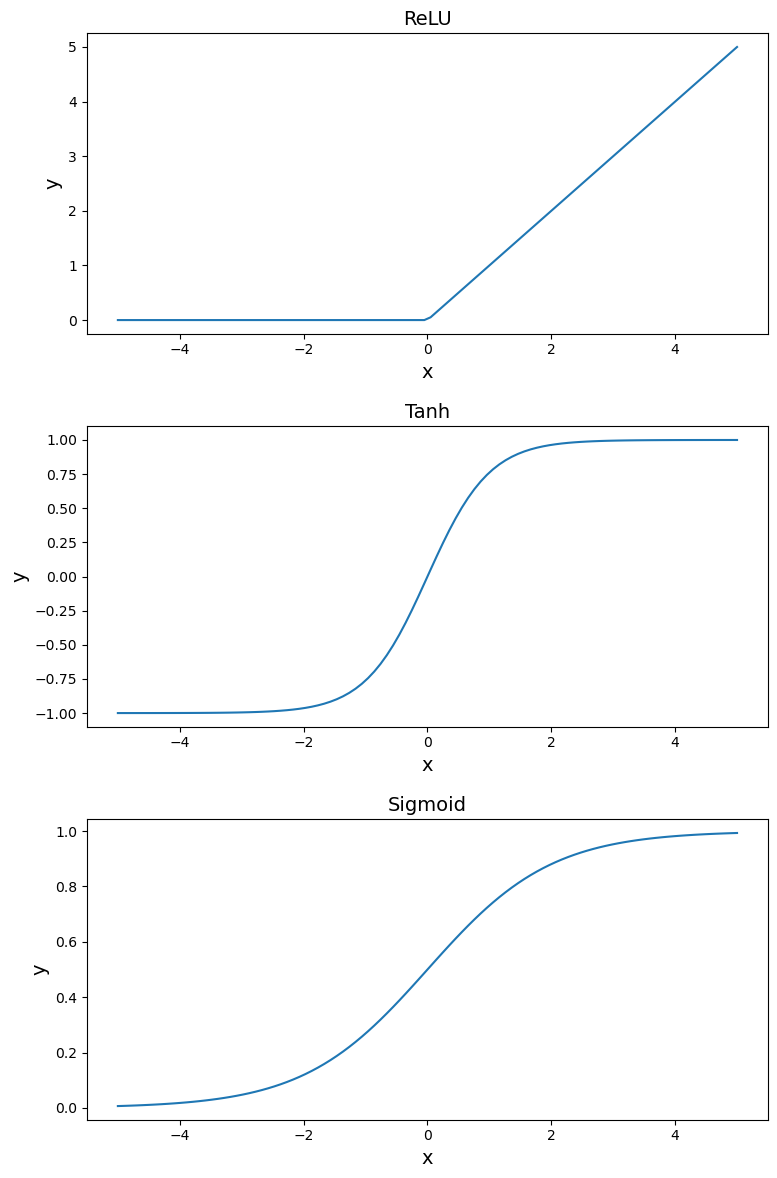

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Define the activation functions
def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Generate a range of x values
x = np.linspace(-5, 5, 100)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot ReLU
axs[0].plot(x, relu(x))
axs[0].set_title('ReLU')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot tanh
axs[1].plot(x, tanh(x))
axs[1].set_title('Tanh')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Plot sigmoid
axs[2].plot(x, sigmoid(x))
axs[2].set_title('Sigmoid')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')

plt.tight_layout()
plt.show()

6. Suppose you have an MLP composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons. All artificial neurons use the ReLU activation function.

Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:

a. what is the shape of the input matrix $\textbf{X}$?

ans: the matrix  $\textbf{X}$ has shape $m × 10$, where $m$ represents the training batch size.

b. What are the shapes of the hidden layer's weight matrix $\textbf{W}_h$ and bias vector $\textbf{b}_h$?

ans: The shape of the hidden layer's weight matrix $\textbf{W}_h$ is $10 × 50$, and the length of its bias vector $\textbf{b}_h$ is 50.

c. What are the shapes of the output layer's weight matrix $\textbf{W}_o$ and bias vector $\textbf{b}_o$?

ans: The shape of the hidden layer's weight matrix $\textbf{W}_o$ is $50 × 3$, and the length of its bias vector $\textbf{b}_0$ is 3.

d. What is the shape of the networks output matrix $\textbf{Y}$?

ans: The shape of the network's output matrix $\textbf{Y}$ is $m × 3$.

e. $\textbf{Y} = ReLU(ReLU(\textbf{X} \textbf{W}_h + \textbf{b}_h) \textbf{W}_o + \textbf{b}_o)$. Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called broadcasting.

7. How many neurons do you need in the output layer if you want to classify email into spam or ham?

ans: 1. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. 

What activation function should you use in the output layer?

ans: You would typically use the sigmoid activation function in the output layer when estimating a probability.

If instead you wanted to tackle MNIST, how many neurons do you need in the output layer and which activation function should you use?

ans: 10 / softmax

What about for getting your network to predict housing prices like in Ch2?

ans: If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log v) = v).




10. Exercise: Train a deep MLP on the MNIST dataset (you can load it using ```tf.keras.datasets.mnist.load_data()```. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

TODO: update this solution to use Keras Tuner.

Let's load the dataset:

In [109]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()